In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.table as table

#First, set up the catalog by loading in the table, and generating the concensus number of arms for each galaxy

In [3]:
vagc_t11 = table.Table.read('t11_vagc.fits')
vagc_t11 = vagc_t11[(0.02 <= vagc_t11['Z_1a']) * (vagc_t11['Z_1a'] <= 0.08)]
vagc_t11 = vagc_t11[vagc_t11['NEXPECT'] > 0.4]

#vagc_t11

In [4]:
N_GDVF = np.zeros(len(vagc_t11)).astype(int)
DVFs = np.column_stack((np.asarray(vagc_t11['t11_arms_number_a31_1_debiased']), 
                        np.asarray(vagc_t11['t11_arms_number_a32_2_debiased']),
                        np.asarray(vagc_t11['t11_arms_number_a33_3_debiased']), 
                        np.asarray(vagc_t11['t11_arms_number_a34_4_debiased']),
                        np.asarray(vagc_t11['t11_arms_number_a36_more_than_4_debiased']),
                        np.asarray(vagc_t11['t11_arms_number_a37_cant_tell_debiased'])))

VF_max = np.max(DVFs, axis = 1)
VF_amax = np.argmax(DVFs, axis = 1)

N_GDVF[(np.equal(np.repeat(VF_max[np.newaxis], DVFs.shape[1], axis = 0).T, DVFs).sum(axis = 1)) == 0] = 0
N_GDVF[(np.equal(np.repeat(VF_max[np.newaxis], DVFs.shape[1], axis = 0).T, 
                 DVFs).sum(axis = 1)) != 0] = VF_amax[(np.equal(np.repeat(VF_max[np.newaxis], DVFs.shape[1], 
                                                                          axis = 0).T, DVFs).sum(axis = 1)) != 0]
vagc_t11.add_column(table.Column(data = N_GDVF, name = 'N_arms'))

#Do the boxplots and violin plots

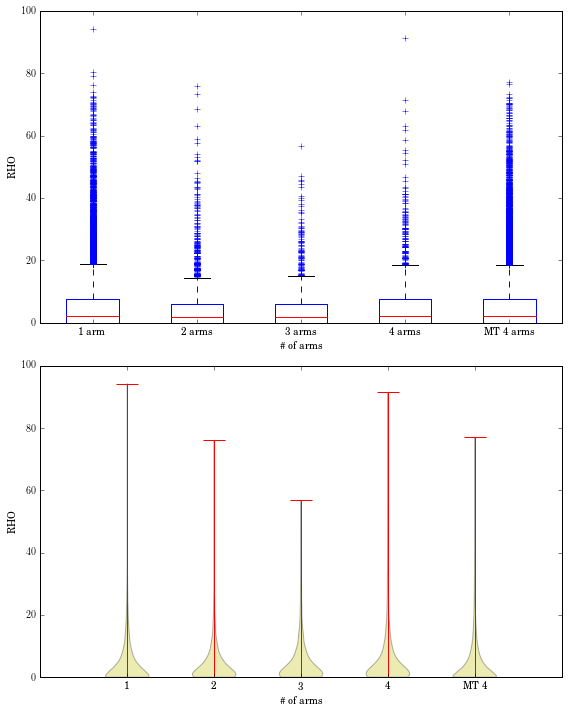

In [5]:
plt.figure(figsize = (8, 10))
ax1 = plt.subplot(211) #boxplots
ax2 = plt.subplot(212) #violinplots

ax1.boxplot(
    x = [vagc_t11['RHO'][vagc_t11['N_arms'] == 1],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 2],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 3],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 4],
        vagc_t11['RHO'][vagc_t11['N_arms'] == 5]],
    labels = ['1 arm', '2 arms', '3 arms', '4 arms',
             'MT 4 arms']
)

#ax1.set_yscale('log')
ax1.set_xlabel('\# of arms')
ax1.set_ylabel('RHO')

ax2.violinplot(
    [vagc_t11['RHO'][vagc_t11['N_arms'] == 1],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 2],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 3],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 4],
    vagc_t11['RHO'][vagc_t11['N_arms'] == 5]],
    [1, 2, 3, 4, 5], points = 1000
)

ax2.set_xticks([1,2,3,4,5])
ax2.set_xticklabels(['1', '2', '3', '4', 'MT 4'])
ax2.set_ylabel('RHO')
ax2.set_xlabel('\# of arms')

plt.tight_layout()

plt.show()

#Now do a KDE for the full sample in RHO-space

In [6]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity

In [10]:
n_full = len(vagc_t11['RHO'])
n_N1 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 1])
n_N2 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 2])
n_N3 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 3])
n_N4 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 4])
n_mt4 = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 5])
n_ct = len(vagc_t11['RHO'][vagc_t11['N_arms'] == 6]) #zero

bandwidth_1 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 1])*n_N1**-0.2
bandwidth_2 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 2])*n_N2**-0.2
bandwidth_3 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 3])*n_N3**-0.2
bandwidth_4 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 4])*n_N4**-0.2
bandwidth_mt4 = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 5])*n_mt4**-0.2
#bandwidth_ct = 1.06*np.std(vagc_t11['RHO'][vagc_t11['N_arms'] == 6])*n_ct**-0.2
print 'bandwidths:'
print zip(['1', '2', '3', '4', 'MT4'], [bandwidth_1, bandwidth_2, bandwidth_3, bandwidth_4, bandwidth_mt4])

kde_full = kde_sklearn(vagc_t11['RHO'], rho_grid, bandwidth=bandwidth_full)
kde_1 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 1], rho_grid, bandwidth=bandwidth_1)
kde_2 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 2], rho_grid, bandwidth=bandwidth_2)
kde_3 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 3], rho_grid, bandwidth=bandwidth_3)
kde_4 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 4], rho_grid, bandwidth=bandwidth_4)
kde_mt4 = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 5], rho_grid, bandwidth=bandwidth_mt4)
#kde_ct = kde_sklearn(vagc_t11['RHO'][vagc_t11['N_arms'] == 6], rho_grid, bandwidth=bandwidth_ct)

bandwidths:
[('1', 1.1267770664898054), ('2', 1.5508656388870135), ('3', 1.8368556226404433), ('4', 2.0071806166058943), ('MT4', 1.0611153013820591)]


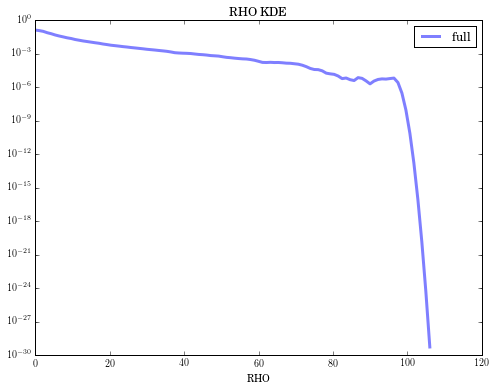

In [21]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

rho_grid = np.linspace(0., 1.1*np.max(vagc_t11['RHO']), 100)

bandwidth_full = 1.06*np.std(vagc_t11['RHO'])*(len(vagc_t11['RHO']))**-0.2

fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)

ax.plot(rho_grid, kde_sklearn(vagc_t11['RHO'], rho_grid, bandwidth=bandwidth_full),
        label='full', linewidth=3, alpha=0.5)
ax.set_title('RHO KDE')
ax.set_xlabel('RHO')
ax.set_yscale('log')

#ax.set_yscale('log')
ax.legend(loc = 'best')

plt.show()

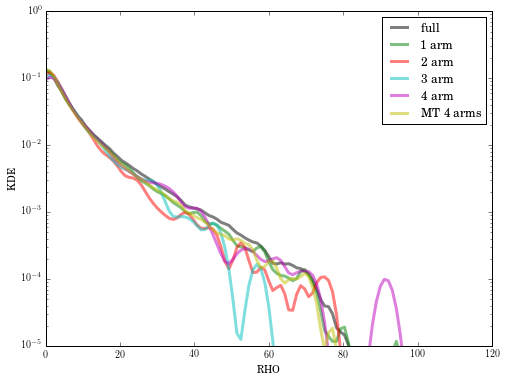

In [19]:
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)

ax.plot(rho_grid, kde_full, label = 'full', linewidth=3, alpha = 0.5, c = 'k')
ax.plot(rho_grid, kde_1, label='1 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_2, label='2 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_3, label='3 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_4, label='4 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_mt4, label='MT 4 arms', linewidth=3, alpha=0.5)

ax.set_xlabel('RHO')
ax.set_ylabel('KDE')

ax.set_yscale('log')
ax.set_ylim([10**-5., 1.])
ax.legend(loc = 'best')

plt.show()

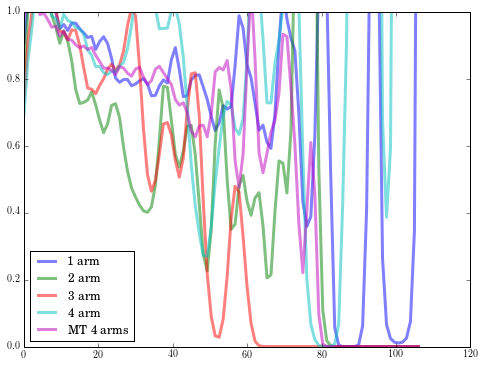

In [15]:
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)

ax.plot(rho_grid, kde_1/kde_full, label='1 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_2/kde_full, label='2 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_3/kde_full, label='3 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_4/kde_full, label='4 arm', linewidth=3, alpha=0.5)
ax.plot(rho_grid, kde_mt4/kde_full, label='MT 4 arms', linewidth=3, alpha=0.5)

ax.legend(loc = 'best')
ax.set_ylim([0., 1])

plt.show()